<a href="https://colab.research.google.com/github/vs74/EEG/blob/LSTM/Notebooks/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from  tensorflow.keras import optimizers
from  tensorflow.keras.callbacks import *

#import models
#from Linear_Regression import linear_regression 

#import datetime for tensorboard
from datetime import *

#Import for reading the MATLAB files
import glob


In [59]:
!ls

1filtered.mat  drive  sample_data


In [0]:
#Import for Loading EEG data from Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Copy the content from the drive folder to the root directory
!cp /content/drive/My\ Drive/EEG_data/1filtered.mat /content/

In [5]:
#Check the data is downloaded or not
!ls

1filtered.mat  drive  sample_data


In [2]:
#Ensure Google COlab is utilising GPU 
tf.test.gpu_device_name()


''

In [0]:
#Ensure that GPU memory utilisation is full
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=4ff694d579c31c16824bc122fccc92159571b36d88025749fa38a4252b08b4c9
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.1 GB  | Proc size: 576.0 MB
GPU RAM Free: 16015MB | Used: 265MB | Util   2% | Total 16280MB


In [8]:
!ls

1filtered.mat  drive  sample_data


In [3]:


# data import from matlab
subject_1 = sio.loadmat('1filtered.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [0]:
#Visualize Using Tenosrboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


In [5]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

window = input ('''Enter the number of stimuli:''')
window = int(window)

n_channel = input('''Enter  the chanel number for which you want your predicion''')
n_channel = list(map(int, n_channel.split()))


relation = input('''Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):''')

if relation == '1':
    response = input("Do you want to embed information of EEG as well ? ( 1 for yes or 2 for no)")
    if response == "2":
      source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
      source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X
    else:
      source_Y = electi[0]
      source_X = [0] + electi[0]

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi
    
elif relation == '3':
    response = input("Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)") 
    if response == "2":
      source_Y = n_channel
      source_X = electi
    else: 
      source_Y = n_channel
      source_X = electi + [0]       


Enter the electrode number:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
<class 'list'>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Enter the number of stimuli:160
Enter  the chanel number for which you want your predicion1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
Please define what should be predicted (1 for EEG from stimulus or 2 for stimulus from EEG or 3 for EEG forecasting ):3
Do you want to embed information of Stimuli as well ? ( 1 for yes or 2 for no)2


In [0]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [0]:
trials_train = np.array([172, 125, 136,  99,  82,  31, 133,  44, 183, 184, 142, 121,  18,
        89, 141,  27, 107,  49,  68, 186,  70,  92, 109,   6, 147, 124,
       117, 161, 137,  39, 157, 159,   4,  23,  25, 145, 179, 118, 163,
       106,  69, 187,  76, 108, 188,  32, 178,  19,  26,  72, 168, 158,
        55,   8, 167,  11,  30,  59,  80,  95,  60, 148, 153,  45,  20,
       152,  73,  48,  36, 100, 185, 131, 138,   3,  13,  97, 126, 171,
       130,  54,   2,  50,  75,  83,  33, 174, 140,  79, 113, 146,  81,
        64,  63,  46, 170,  16, 173, 156,  90, 103, 144,  29,  58,  47,
       105, 189,  56,  34,  12, 165, 122, 119,  94,  42,  24,  37,  14,
        65,  93,  87, 154,  77, 166, 114, 112, 160, 164,  51, 139,  84,
       169,  85, 162,  88,  66, 155,  78,  28,   9,   1,  98, 132, 175,
       177, 115,  96, 111,  52,  21, 180,  61, 191, 143,  10])

trials_valid = np.array([ 67,  15,  38,  22,   0,  74, 182, 151,  91,  43,  53, 123, 127,
       128, 149, 190, 134, 102, 181])

trials_test = np.array([116,  57, 110,   7,  40, 176, 150,  41, 120, 135, 101,  71,  62,
        86, 129,  35, 104,   5,  17])

In [0]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    

In [0]:
# extract Y for Muti Channel Prediction
def extract_Y (batch_trials, batch_num, horizon, multivariate = False):             #creation of a function to recover y - simplification of reading
    y = []
    for idx, i in enumerate(source_Y):
      y_tmp = []
      for j in batch_trials:
        tmp = rolling_window(format_1[i, j, 160:], horizon)
        y_tmp.append(tmp)
      y.append(np.vstack(y_tmp))
    if multivariate:
      y= np.moveaxis(np.array(y), 0, -1)      
    else: 
      y = np.hstack(y)  
    return  y           
  

In [10]:
y_train = extract_Y (trials_train, train_num, horizon  = 1, multivariate= False)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num, horizon  = 1, multivariate = False)
print ("y_valid.shape = ", y_valid.shape)

y_train.shape =  (129360, 64)
y_valid.shape =  (15960, 64)


In [11]:
y_test = extract_Y (trials_test, test_num, horizon  = 840, multivariate = True)
print ("y_test.shape = ", y_test.shape)

y_test.shape =  (19, 840, 64)


In [0]:

def extract_X (batch_trials, batch_num, horizon = 1):                     #creation of a function to recover x - simplification of reading
  
    x = np.zeros((len(source_X),  batch_num * (time_points - window - horizon + 1 ), window ))                                     
    for idx, i in enumerate(source_X):                                      #reading the source list -> reading each electrode number if flip
      x_tmp = []
      for j in batch_trials:
        tmp = rolling_window(format_1[i, j, :-horizon], window)
        x_tmp.append(tmp)
      x[idx] = np.vstack(x_tmp)

    x = np.hstack(x)
    x = np.array(np.split(x, len(source_X), axis = -1))
    x = np.moveaxis(x, 0, -1)
    return x


In [13]:

x_train = extract_X (trials_train, train_num, horizon = 1)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num, horizon = 1)
print ("x_valid.shape = ", x_valid.shape)

x_train.shape =  (129360, 160, 64)
x_valid.shape =  (15960, 160, 64)


In [14]:

x_test = extract_X (trials_test, test_num, horizon = 840)
print ("x_test.shape = ", x_test.shape)

x_test.shape =  (19, 160, 64)


In [15]:

train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160, 64)
(129360, 64)


In [16]:
#Sanity Check dimension of Inout
print("Shape of Train_X  = ", train_X.shape)
print("Shape of Valid_X  = ", valid_X.shape)
print("Shape of Test_X   = ",test_X.shape )

Shape of Train_X  =  (129360, 160, 64)
Shape of Valid_X  =  (15960, 160, 64)
Shape of Test_X   =  (19, 160, 64)


In [17]:
K.clear_session()

NameError: ignored

In [0]:
import numpy as np
from keras.layers import LSTMCell, GRUCell, RNN, SimpleRNNCell, Dense, Input, Flatten, Concatenate
from keras import Model
from keras import backend as K
from keras.metrics import get
from tqdm import tqdm


In [0]:
model_name = "LSTM"
optimizer_name = "sgd"
training_epochs = 200
batch_size = 1024

layers = 1
learning_rate = 0.1
normalized_data = True
features = train_X.shape[-1]

In [0]:


class RecurrentNN(object):
    """
    A wrapper around the RNN, LSTM and GRU classes that allows to build model
    and performs predictions using two different multi-step forecasting strategies:
    Multiple Input Multiple Output (MIMO) and Recursive
    """

    def __init__(self, layers, cell_type, cell_params):
        """
        Build the rnn with the given number of layers.
        :param layers: list
            list of integers. The i-th element of the list is the number of hidden neurons for the i-th layer.
        :param cell_type: 'gru', 'rnn', 'lstm'
        :param cell_params: dict
            A dictionary containing all the paramters for the RNN cell.
            see keras.layers.LSTMCell, keras.layers.GRUCell or keras.layers.SimpleRNNCell for more details.
        """
        # init params
        self.model = None
        self.horizon = None
        self.layers = layers
        self.cell_params = cell_params
        if cell_type == 'lstm':
            self.cell = LSTMCell
        elif cell_type == 'gru':
            self.cell = GRUCell
        elif cell_type == 'rnn':
            self.cell = SimpleRNNCell
        else:
            raise NotImplementedError('{0} is not a valid cell type.'.format(cell_type))
        # Build deep rnn
        self.rnn = self._build_rnn()

    def _build_rnn(self):
        cells = []
        for _ in range(self.layers):
            cells.append(self.cell(**self.cell_params))
        deep_rnn = RNN(cells, return_sequences=False, return_state=False)
        return deep_rnn

    def build_model(self, input_shape, horizon):
        pass

    def predict(self, inputs):
        pass

    def evaluate(self, inputs):
        pass

    def _eval(self, y, y_hat):
        results = []
        for m in self.model.metrics:
            if isinstance(m, str):
                results.append(K.eval(K.mean(get(m)(y, y_hat))))
            else:
                results.append(K.eval(K.mean(m(y, y_hat))))
        return results


In [0]:


class RecurrentNN_Rec(RecurrentNN):
    """
    Recurrent Neural network using Recursive forecasting startegy.
    The model's training and predictions phase are different.
    """

    def __init__(self, *args, **kwargs):
        self.return_sequence = False
        super().__init__(*args, **kwargs)

    def build_model(self, input_shape, horizon):
        """
        Create a Model that takes as inputs:
            - 3D Tensor of shape (batch_size, window_size, n_features)
        and outputs:
            - 2D tensor of shape (batch_size, 1)
        :param input_shape:
            (window_size, n_features)
        :param horizon: int
            The forecasting horizon
        :return: a keras Model
        """
        self.horizon = horizon
        if len(input_shape) < 2:
            input_shape = (input_shape[0], 1)
        inputs = Input(shape=input_shape, dtype='float32')
        out_rnn = self.rnn(inputs)                    # [batch_size, hidden_state_length]
        outputs = Dense(1, activation=None)(out_rnn)  # [batch_size, 1]

        self.model = Model(inputs=[inputs], outputs=[outputs])
        self.model.summary()
        print("Hello")
        return self.model

    def predict(self, inputs, exogenous=None):
        """
        Perform recursive prediction by feeding the network input at time t+1 with the prediction at
        time t. This is repeted 'horizon' number of time.
        :param input: np.array
            (batch_size, window_size, n_features), n_features is supposed to be 1 (univariate time-series)
        :param exogenous: np.array
            exogenous feature for the loads to be predicted
            (batch_size, horizon, n_exog_features)
        :return: np.array
            (batch_size, horizon)
        """
        input_seq = inputs                                         # (batch_size, n_timestamps, n_features)
        output_seq = np.zeros((input_seq.shape[0], self.horizon))  # (batch_size, horizon)
        for i in tqdm(range(self.horizon)):
            if self.return_sequence:
                output = self.model.predict(input_seq)             # [batch_size, input_timesteps]
                output = output[:,-1:]
            else:
                output = self.model.predict(input_seq)             # [batch_size, 1]
            input_seq[:, :-1, :] = input_seq[:, 1:, :]
            input_seq[:, -1:, 0] = output
            if exogenous is not None:
                input_seq[:, -1, 1:] = exogenous[:, i, :]
            # input_seq = np.concatenate([input_seq[:, 1:, :], np.expand_dims(output,axis=-1)], axis=1)
            output_seq[:, i] = output[:,0]
        return output_seq

    def evaluate(self, inputs, fn_inverse=None, fn_plot=None):
        try:
            X, y = inputs
        except:
            X, y, _ = inputs
        try:
            X, exogenous = X
        except:
            exogenous = None
        print(y.shape)
        y_hat = self.predict(X, exogenous)

        return y_hat

        '''
        if fn_inverse is not None:
            y_hat = fn_inverse(y_hat)
            y = fn_inverse(y)

        if fn_plot is not None:
            fn_plot([y, y_hat])

        return self._eval(y, y_hat)
        '''

In [0]:


class RecurrentNN_MIMO(RecurrentNN):
    """
    Recurrent Neural network using MIMO forecasting startegy.
    """

    def build_model(self, input_shape, horizon, exogenous_shape=None):
        """
        Create a Model that takes as inputs:
            - 3D Tensor of shape (batch_size, window_size, n_features)
            - (optional) 3D Tensor of shape (batch_size, window_size, n_features-1)
        and outputs:
            - 2D tensor of shape (batch_size, horizon)
        :param input_shape:
            (window_size, n_features)
        :param horizon: int
            The forecasting horizon
        :param conditions_shape:
            (horizon, n_features)
        :return: a keras Model
        """
        self.horizon = horizon
        if len(input_shape) < 2:
            input_shape = (input_shape[0], 1)
        inputs = Input(shape=input_shape, dtype='float32', name='input')
        # [batch_size, hidden_state_length]
        out_rnn = self.rnn(inputs)

        if exogenous_shape is not None:
            # Include exogenous in the prediction
            exogenous = Input(exogenous_shape, dtype='float32', name='exogenous')  # [batch_size, horizon, n_features]
            out_rnn = Dense(horizon, activation='relu')(out_rnn)
            ex = Flatten()(exogenous)                                              # [batch_size, horizon * n_features]
            ex = Dense(horizon, activation='relu')(ex)
            out_rnn = Concatenate()([out_rnn, ex])                                 # [batch_size, 2*horizon]

        # [batch_size, horizon]
        outputs = Dense(horizon, activation=None)(out_rnn)

        if exogenous_shape is not None:
            self.model = Model(inputs=[inputs, exogenous], outputs=outputs)
        else:
            self.model = Model(inputs=[inputs], outputs=[outputs])
        self.model.summary()
        return self.model

    def predict(self, inputs):
        """
        :param inputs: np.array
            (batch_size, window_size, n_features)
        :return: np.array
            (batch_size, horizon)
        """
        return self.model.predict(inputs)

    def evaluate(self, inputs, fn_inverse=None, fn_plot=None):
        try:
            X, y_exog, y = inputs
            y_hat = self.model.predict([X, y_exog])
        except:
            X, y = inputs
            y_hat = self.model.predict(X)
        y_hat = np.asarray(y_hat, dtype=y.dtype)


        return y_hat
        '''

        if fn_inverse is not None:
            y_hat = fn_inverse(y_hat)
            y = fn_inverse(y)

        if fn_plot is not None:
            fn_plot([y, y_hat])

        return self._eval(y, y_hat)
        '''


In [0]:
from keras.regularizers import l2

In [0]:
  cell_params = dict(units=units,
                      activation='tanh',
                      dropout=0.1,
                      kernel_regularizer=l2(0.001),
                      recurrent_regularizer=l2(0.001),
                      kernel_initializer='lecun_uniform',
                      recurrent_initializer='lecun_uniform')

In [0]:
rnn = RecurrentNN_Rec(cell_type='lstm',
                              layers=1,
                              cell_params=cell_params)

In [0]:
model = rnn.build_model(input_shape=(160, 1),
                                horizon=2)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 160, 1)            0         
_________________________________________________________________
rnn_9 (RNN)                  (None, 5)                 140       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
Hello


In [0]:
#Set up the Optimizers
sgd = optimizers.SGD(learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = "mse", optimizer = sgd , metrics=["mse"])

In [0]:
 history = model.fit(x_train, y_train,
                        validation_data = (x_valid, y_valid),
                        batch_size = 1024,
                        # steps_per_epoch= train.shape[0] // params['batch_size'],
                        epochs=200,
                        verbose=1)

Train on 129360 samples, validate on 15960 samples
Epoch 1/20
129360/129360 [==============================] - 40s 309us/step - loss: 0.8210 - mean_squared_error: 0.7757 - val_loss: 0.7629 - val_mean_squared_error: 0.7176
Epoch 2/20
129360/129360 [==============================] - 39s 300us/step - loss: 0.7838 - mean_squared_error: 0.7385 - val_loss: 0.7266 - val_mean_squared_error: 0.6813
Epoch 3/20
129360/129360 [==============================] - 38s 297us/step - loss: 0.7525 - mean_squared_error: 0.7073 - val_loss: 0.6962 - val_mean_squared_error: 0.6509
Epoch 4/20
129360/129360 [==============================] - 38s 296us/step - loss: 0.7262 - mean_squared_error: 0.6810 - val_loss: 0.6704 - val_mean_squared_error: 0.6252
Epoch 5/20
129360/129360 [==============================] - 39s 298us/step - loss: 0.7041 - mean_squared_error: 0.6589 - val_loss: 0.6482 - val_mean_squared_error: 0.6031
Epoch 6/20
129360/129360 [==============================] - 39s 298us/step - loss: 0.6848 - me

In [0]:
def predict(model, input, horizon = 2, return_sequence = False):
    """
    Perform recursive prediction by feeding the network input at time t+1 with the prediction at
    time t. This is repeted 'horizon' number of time.
    :param input: np.array
        (batch_size, window_size, n_features), n_features is supposed to be 1 (univariate time-series)
    :param exogenous: np.array
        exogenous feature for the loads to be predicted
        (batch_size, horizon, n_exog_features)
    :return: np.array
        (batch_size, horizon)
    """
    input_seq = input                                         # (batch_size, n_timestamps, n_features)
    output_seq = np.zeros((input_seq.shape[0], horizon, input_seq.shape[-1] - 1))  # (batch_size, horizon, n_features)
    for i in tqdm(range(horizon)):
        if return_sequence:
            output = model.predict(input_seq, verbose = 1)             # [batch_size, input_timesteps]
            output = output[:,-1:]
        else:
            output = model.predict(input_seq, verbose = 1)             # [batch_size, n_features]
            print(output.shape)
        input_seq[:, :-1, :] = input_seq[:, 1:, :]                    
        print(input_seq.shape)
        print(output_seq.shape)
        input_seq[:, -1:, 1:] = output
        '''if exogenous is not None:
            input_seq[:, -1, 1:] = exogenous[:, i, :]
        '''
        # input_seq = np.concatenate([input_seq[:, 1:, :], np.expand_dims(output,axis=-1)], axis=1)
        output_seq[:, i, :] = output[:,0]
    return output_seq

In [56]:
predictions = predict(model, x_test, horizon = 840)

  0%|          | 0/840 [00:00<?, ?it/s]

19/19 [==============================] - 0s 3ms/sample


  0%|          | 0/840 [00:00<?, ?it/s]

(19, 64)
(19, 160, 65)
(19, 840, 64)


ValueError: ignored

In [0]:
from tqdm import tqdm

In [0]:
print(predictions.shape)

(15941, 2)


In [0]:
y_test

array([[ 2.3953069 ,  2.7110921 ],
       [ 2.7110921 ,  2.95549735],
       [ 2.95549735,  2.43877453],
       ...,
       [-0.92890832, -0.56058633],
       [-0.56058633, -0.74179912],
       [-0.74179912, -0.39280196]])

In [0]:
predictions

array([[ 0.55388373,  0.60830188],
       [ 0.56456625,  0.59624112],
       [ 0.54436743,  0.57120228],
       ...,
       [-0.95175695, -0.88760197],
       [-0.88382959, -0.87295794],
       [-0.81254745, -0.83628845]])

In [0]:
r

array([[ 0.61603963,  0.61068666],
       [ 0.59882915,  0.59112507],
       [ 0.57742494,  0.57052612],
       ...,
       [-0.87472141, -0.87066698],
       [-0.86917818, -0.86540365],
       [-0.83611655, -0.83188939]])

In [0]:
print(y_test.shape)

(15941, 2)


In [0]:
r = rnn.evaluate([x_test, y_test])


  0%|          | 0/2 [00:00<?, ?it/s]

(15941, 2)



100%|██████████| 2/2 [01:41<00:00, 50.55s/it]


In [0]:
test_scores.shape

(15960, 2)

In [26]:
K.clear_session()

In [0]:
#Parameters of model
model_name = "LSTM"
optimizer_name = "sgd"
training_epochs = 200
batch_size = 1024
layers = 1
units = 95
learning_rate = 0.1
activation = "relu"
features = train_X.shape[-1]

In [0]:
 def predict(self, inputs, exogenous=None):
        """
        Perform recursive prediction by feeding the network input at time t+1 with the prediction at
        time t. This is repeted 'horizon' number of time.
        :param input: np.array
            (batch_size, window_size, n_features), n_features is supposed to be 1 (univariate time-series)
        :param exogenous: np.array
            exogenous feature for the loads to be predicted
            (batch_size, horizon, n_exog_features)
        :return: np.array
            (batch_size, horizon)
        """
        input_seq = inputs                                         # (batch_size, n_timestamps, n_features)
        output_seq = np.zeros((input_seq.shape[0], self.horizon))  # (batch_size, horizon)
        for i in tqdm(range(self.horizon)):
            if self.return_sequence:
                output = self.model.predict(input_seq)             # [batch_size, input_timesteps]
                output = output[:,-1:]
            else:
                output = self.model.predict(input_seq)             # [batch_size, 1]
            input_seq[:, :-1, :] = input_seq[:, 1:, :]
            input_seq[:, -1:, 0] = output
            if exogenous is not None:
                input_seq[:, -1, 1:] = exogenous[:, i, :]
            # input_seq = np.concatenate([input_seq[:, 1:, :], np.expand_dims(output,axis=-1)], axis=1)
            output_seq[:, i] = output[:,0]
        return output_seq

In [0]:
def vanilla_RNN(layers, units, features):
    inp = Input([window, features])
    X = inp
    for i in range(layers - 1):
      X = LSTM(units, return_sequences = True)(X)
    X = LSTM(units)(X)
    out = Dense(len(source_Y), kernel_initializer = 'normal')(X)
    
    model = Model(inputs = inp, outputs = out)
    #Set up the Optimizers
    sgd = optimizers.SGD(learning_rate)
    adam = optimizers.Adam(lr = learning_rate)
    rmsprop = optimizers.RMSprop(lr = learning_rate)

    #Compile the model
    model.compile(loss = "mse", optimizer = sgd , metrics=["mse"])
    return model 
    
    

In [20]:
#Define Keras Model 
model = vanilla_RNN( layers, units, features)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
hidden_layers

NameError: ignored

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 65)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 95)                61180     
_________________________________________________________________
dense (Dense)                (None, 64)                6144      
Total params: 67,324
Trainable params: 67,324
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Make Directory to store Tenorboad Logs
!mkdir logs
!mkdir logs/scalars

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘logs/scalars’: File exists


In [0]:
!apt-get install tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()


In [0]:
#Set Up Tensorboard for visualisation for training
Name = "{} + optimizer_{} + batch_size_{} + epochs_{} + Layer_{} + units_{} + learning_rate_{} +  activation_{} + relation_{} + date_".format(model_name, optimizer_name, batch_size, training_epochs, layers, units, learning_rate, activation, relation)
logdir ="logs/scalars/"+ Name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TrainValTensorBoard(log_dir=logdir, write_images = True, histogram_freq = 2)
#Sanity Check for LogDir
print(logdir)

logs/scalars/LSTM + optimizer_sgd + batch_size_1024 + epochs_10 + Layer_1 + units_95 + learning_rate_0.1 +  activation_relu + relation_3 + date_20200323-183111


In [0]:
LOG_DIR = 'logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
#Get url of TensorBoard to Visualise
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
training_epochs = 200


In [0]:
#Fit the model with the Data

history = model.fit(
    x_train, 
    y_train, 
    validation_data= (x_valid, y_valid),
    batch_size = batch_size,
    epochs = training_epochs,
    verbose = 1,
    )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 129360 samples, validate on 15960 samples
Epoch 1/200
129360/129360 [==============================] - 36s 280us/sample - loss: 0.8674 - mean_squared_error: 0.8674 - val_loss: 0.7888 - val_mean_squared_error: 0.7888
Epoch 2/200
129360/129360 [==============================] - 36s 275us/sample - loss: 0.7520 - mean_squared_error: 0.7520 - val_loss: 0.7176 - val_mean_squared_error: 0.7176
Epoch 3/200
129360/129360 [==============================] - 35s 273us/sample - loss: 0.6998 - mean_squared_error: 0.6998 - val_loss: 0.6778 - val_mean_squared_error: 0.6778
Epoch 4/200
129360/129360 [==============================] - 35s 271us/sample - loss: 0.6647 - mean_squared_error: 0.6647 - val_loss: 0.6470 - val_mean_squared_error: 0.6470
Epoch 5/200
129360/129360 [==============================] - 35s 269us/sample - loss: 0.6353 - mean_squared_error: 0.6353 - val_loss: 0.6202 - val_mean_squared

In [29]:
predictions = model.predict(test_X, verbose  = 1)




15960/15960 [==============================] - 24s 2ms/sample


In [0]:
def compute_correlation(true, pred):
    corr_coef = np.corrcoef(true, pred)[0, 1]
    return corr_coef 
    

In [36]:
predictions.shape

(15960, 64)

In [47]:
compute_correlation(y_test, predictions)

0.7774253406510199

In [0]:
def list_correlation(electi, true, pred):
    l = []
    for i in range(true.shape[0]):
        l.append(compute_correlation(true[i, :], pred[i,: ]))
    return l

In [0]:
k = list_correlation(electi, y_test, predictions)

In [39]:
k

[0.7995549463546774,
 0.759637157211194,
 0.7336911480045082,
 0.8086965598478387,
 0.7090263577977994,
 0.7249174334561422,
 0.6762698662668182,
 0.716898239641389,
 0.7163485546063122,
 0.8174591702587054,
 0.6930340605394494,
 0.7613989928596746,
 0.618210651416681,
 0.4972294865034221,
 0.5411813455846635,
 0.5837259524305457,
 0.8462300399454272,
 0.7424514778325689,
 0.8228628811084799,
 0.780368501537682,
 0.7766337997390456,
 0.8164661601631938,
 0.8264447365105794,
 0.74527354607218,
 0.7344800592013538,
 0.5125666363016317,
 0.9050190876121972,
 0.7990965976094256,
 0.8466088262163699,
 0.843266488395759,
 0.5590622197363528,
 0.5670767764320032,
 0.6595339437851437,
 0.7951144482175806,
 0.9175218941539207,
 0.9346511621745097,
 0.7885891948452941,
 0.8816666510102933,
 0.8811053361838669,
 0.8688472868303797,
 0.8305851353673651,
 0.5592305575711873,
 0.7442231679786143,
 0.8169494266890649,
 0.866000626395243,
 0.8381508076141517,
 0.848029958259288,
 0.7155115167534327,
 

In [0]:
def convert_to_csv():
  frame = pd.DataFrame()

In [0]:
#Graphical Display to plot weights
def plot_weights(weights, electi):
 
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = weights[0].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(K.constant(weights[0]), [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, K.eval(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    

(160, 1)


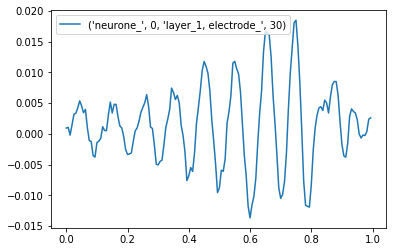

In [0]:
weights = np.array(model.get_weights()) #Convert the weights into np array

plot_weights(weights, electi)            #Plot the weights of the model

In [0]:
weights.shape

(2,)